# Naive transformer
In this notebook we start implementing a 'naive' version of a GPT-style transformer architecture for educational purposes. The main idea is to focus on the most simple form of the attention mechanism (i.e. dot product softmax attention, without batching), and plug that into a transformer setup. We don't expect good performance on text generation yet, and training will be relatively slow since we don't implement a batch dimension.

In [ ]:
# All dependencies for the entire notebook
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import RandomSampler, random_split

import math
from tqdm.auto import tqdm, trange
from matplotlib import pyplot as plt

DEVICE = torch.device('mps')

## Data
We once again turn to the tiny shakespeare dataset

In [2]:
# Download the tiny shakespeare dataset
!wget -nc https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

File ‘input.txt’ already there; not retrieving.



We use a character level tokenizer and a dataset class to select a context of a given size and the next tokens to predict. Very similar to what we used for n-gram markov prediction and 1D CNN models.

In [ ]:
class CharacterTokenizer:
    """Character level tokenizer that enumerates unique characters in a training text"""
    def __init__(self, encoding_dict: dict[str, int]=None):
        if encoding_dict is None:
            self.encoding_dict = dict()
        else:
            self.encoding_dict = encoding_dict

    def __repr__(self):
        return f'CharacterTokenizer(vocab_size={self.vocab_size})'

    @property
    def decoding_dict(self) -> dict[int, str]:
        """Decoding dict is implemented as property to automatically sync with changed encoding dict"""
        return {token:char for char,token in self.encoding_dict.items()}

    @property
    def vocab_size(self) -> int:
        return len(self.encoding_dict)

    def get_vocab(self) -> dict[str, int]:
        return self.encoding_dict

    def train(self, data: str) -> None:
        """Train on a piece of text by enumerating unique characters"""
        chars = sorted(set(data))
        self.encoding_dict = {char:token for token,char in enumerate(chars)}

    def encode(self, data: str) -> list[int]:
        """Convert text to tokens"""
        return [self.encoding_dict.get(char, -1) for char in data]

    def decode(self, tokens: list[int]) -> str:
        """Convert tokens to text"""
        return ''.join(self.decoding_dict.get(token, '<unk>') for token in tokens)

class CharacterDataset:
    def __init__(self, data: str, tokenizer: CharacterTokenizer, context_size: int=256):
        self.data = data
        self.tokenizer = tokenizer
        self.vocab_size = len(tokenizer.get_vocab())
        self.context_size = context_size

    def __repr__(self):
        n_chars = len(self.data)
        vocab_size = self.vocab_size
        context_size = self.context_size
        return f'CharacterDataset({n_chars=}, {vocab_size=}, {context_size=})'

    @classmethod
    def from_textfile(cls, filename: str, context_size: int=256) -> 'CharacterDataset':
        """Load a textfile and automatically 'train' a character level tokenizer"""
        tokenizer = CharacterTokenizer()
        with open(filename, 'r') as fh:
            data = fh.read()
            tokenizer.train(data)
            return cls(data, tokenizer, context_size=context_size)

    def __len__(self) -> int:
        return len(self.data) - self.context_size

    def __getitem__(self, pos: int) -> torch.Tensor:
        """Return tokens starting at pos up to pos + context_size, targets are shifted by one position"""
        # grab a chunk of block_size characters from the data
        chunk = self.data[pos:pos + self.context_size + 1]
        # encode every character to an integer
        tokens = self.tokenizer.encode(chunk)
        # convert to tensor
        tokens = torch.tensor(tokens, dtype=torch.long)
        # targets are shifted one position from input
        return tokens[:-1], tokens[1:]

dataset = CharacterDataset.from_textfile('./input.txt')
len(dataset)

1115138

## Model
Below is the entire implementation of a transformer architecture (minus the actual attention mechanism, see exercise 1) in one codeblock. We keep everything in one block so our model is always in sync with any code changes we implement. 

The main components are implemented in seperate classes:

- `DotProductSoftmaxAttention`: Our non-optimized simplest form of the attention mechanism.
- `TransformerBlock`: Executes the `DotProductSoftmaxAttention`, performs layer normalization to keep our gradients well-behaved, and adds a residual connection to let the original signal flow through (which includes for example positional information).
- `AdditivePositionalEmbedding`: A wrapper class to add positional embeddings to previously determined token embeddings.
- `NaiveTransformer`: Combines all of the above functionality and adds dropout and layer normalization in a few places to help with generalization and prevent overfitting. In addition this implements the `generate` method so we can easily sample novel token sequences.

### Exercise 1:
Implement dot product softmax attention in the currently empty `DotProductSoftmaxAttention` class. Remember to define three linear input transformations for queries, keys, and values, and to scale the attention matrix by the embedding dimensionality. If you have properly implemented the attention mechanism, the codeblock below will generate a token sample from an untrained model. Once your model works, continue training it on tinyshakespeare with the codeblock under the 'Training' section, and generate a few samples with the code from the 'Evaluation' section. How does your naive transformer model perform (i.e. compared to yesterdays 1D convolutional neural network)?

In [ ]:
class DotProductSoftmaxAttention(nn.Module):
    """Simplest dot product attention block, no batches"""
    def __init__(self, embedding_dim: int, causal: bool=True):
        super().__init__()
        self.embedding_dim = embedding_dim
        # IMPLEMENT ME

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Calculate dot product attention, input x is not batched!"""
        # IMPLEMENT ME

class DotProductSoftmaxAttention(nn.Module):
    """Simplest dot product attention block, no batches"""
    def __init__(self, embedding_dim: int):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.w_k = nn.Linear(in_features=embedding_dim, out_features=embedding_dim)
        self.w_q = nn.Linear(in_features=embedding_dim, out_features=embedding_dim)
        self.w_v = nn.Linear(in_features=embedding_dim, out_features=embedding_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Calculate dot product attention, input x is not batched!"""
        k = self.w_k(x)
        q = self.w_q(x)
        v = self.w_v(x)

        attention = (k @ q.T) / math.sqrt(self.embedding_dim)

        # uncomment the lines below for causal/masked self-attention
        #mask = torch.tril(attention) == 0
        #attention[mask] = -torch.inf

        return F.softmax(attention, dim=-1) @ v

class TransformerBlock(nn.Module):
    """Transformer block that combines attention with layer normalization and residual connections"""
    def __init__(self, embedding_dim: int):
        super().__init__()
        self.attention = nn.Sequential(
            DotProductSoftmaxAttention(embedding_dim=embedding_dim),
            nn.LayerNorm(embedding_dim)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Calculate attention with residual connections"""
        return self.attention(x) + x 

class AdditivePositionalEmbedding(nn.Module):
    """Wrapper class to add positional encoding to already embedded tokens"""
    def __init__(self, context_size: int, embedding_dim: int):
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings=context_size, embedding_dim=embedding_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Add positional embeddings based on input dimensions, use residual connection"""
        pos = torch.arange(0, x.size(0), dtype=torch.long, device=x.device)
        return self.embedding(pos) + x

class NaiveTransformer(nn.Module):
    """Full transformer architecture, but without optimizations such as batching or dropout"""
    def __init__(self, context_size: int, vocab_size: int, n_layers: int=4, embedding_dim: int=256, dropout: float=0.2,):
        super().__init__()
        self.context_size = context_size
        self.vocab_size = vocab_size
        self.transformer = nn.Sequential(
            nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim),                     # token embedding
            AdditivePositionalEmbedding(context_size, embedding_dim),                                 # add position embedding
            nn.Dropout(dropout),                                                                      # random dropout to decrease overfitting
            nn.Sequential(*[TransformerBlock(embedding_dim=embedding_dim) for _ in range(n_layers)]), # attention layers
            nn.LayerNorm(embedding_dim),                                                              # layer normalization to keep our gradients nice
            nn.Linear(in_features=embedding_dim, out_features=vocab_size),                            # position-wise output projection
            nn.Dropout(dropout)                                                                       # random dropout to decrease overfitting
        )

    def forward(self, x: torch.Tensor, targets: torch.Tensor=None) -> tuple[torch.Tensor, torch.Tensor | None, torch.Tensor | None]:
        """Predict class logits and calculate loss and accuracy if targets are specified"""
        logits = self.transformer(x)
        loss = None if targets is None else F.cross_entropy(logits, targets)
        accuracy = None if targets is None else (logits.argmax(dim=1) == targets).sum() / targets.size(0)
        return logits, loss, accuracy

    def generate(self, sample_length: int=256) -> list[int]:
        """Generate sample tokens"""
        device = next(self.parameters()).device
        idx = torch.tensor([0], dtype=torch.long, device=device)

        for _ in trange(sample_length):
            logits,*_ = self(idx[-self.context_size:])
            logits = logits[-1,:]

            probs = F.softmax(logits, dim=-1)

            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat([idx, idx_next])

        return idx[1:].tolist()

model = NaiveTransformer(context_size=dataset.context_size, vocab_size=dataset.vocab_size)
sample = model.generate()
print(dataset.tokenizer.decode(sample))

  0%|          | 0/256 [00:00<?, ?it/s]

CbmQHieSY:,Na$RBELiT.;3eiqvK;3b$cZHzrwqNJlZD;S:FrBZaF-KR?EBgOjX-:jY$C;q$O!eC-ECjJ,GKNeyuqEESxkjKM:VV$EdHgYzrQoENKCJcqtKAHBxwTJTxrkoZxaTtde.,C,.qsKsGakodsUegtksZeiRYprhte?LECeKa&&o!en?JeMaLduiXVNmJHTXErjZKPrFqdK33FDC,qeciesZr xHZKrO&$KOI?Vu-3$sM:e:KKc3oeyTU


## Training 
The code below configures and trains our 'naive' transformer model on tiny shakespeare. Loss and accuracy for both train and test sets are calculated and saved.

> _Note:_ Training of batched data is implemented in a slightly unusual fashion because our simple `DotProductSoftmaxAttention` is not designed to handle batched input. Instead we loop over every sample in a batch and backpropagate our loss, but we only zero the gradients after we have looked at the entire batch. This technique is called 'gradient accumulation' and is also used to train very large models where only one sample can be loaded into memory simultaneously.

  0%|          | 0/500 [00:00<?, ?it/s]

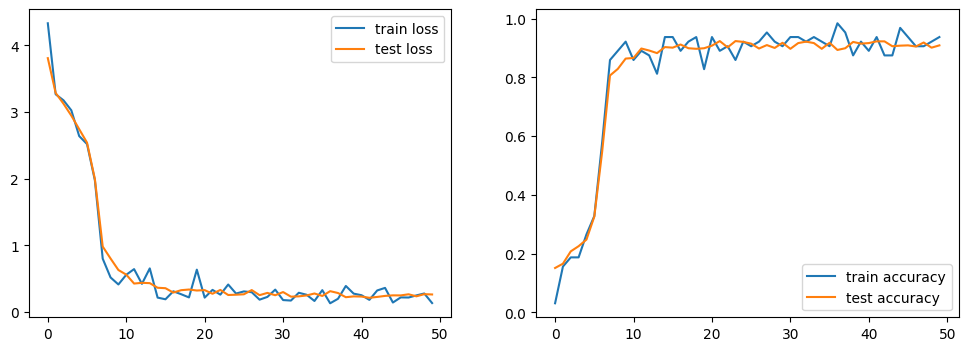

In [15]:
dataset = CharacterDataset.from_textfile('./input.txt', context_size=64)
train_dataset, test_dataset = random_split(dataset, [0.8, 0.2])

model = NaiveTransformer(
    context_size=dataset.context_size,
    vocab_size=dataset.vocab_size,
    embedding_dim=256,
    n_layers=6,
    dropout=0.1,
)
model = model.to(DEVICE)
model.train()

batch_size = 16
n_train_steps = 500

train_dataloader = DataLoader(
    dataset=train_dataset,
    sampler=RandomSampler(train_dataset, num_samples=batch_size * n_train_steps),
    batch_size=batch_size
)

test_dataloader = DataLoader(
    dataset=test_dataset,
    sampler=RandomSampler(test_dataset),
    batch_size=batch_size
)
test_dataloader = iter(test_dataloader)

train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

for i, train_batch in enumerate(tqdm(train_dataloader)):
    model.zero_grad()
    for x,y in zip(*train_batch):
        _,loss,accuracy = model(x.to(DEVICE), y.to(DEVICE))
        # backprop and update the parameters
        loss.backward()
    optimizer.step()

    if i % 10 == 0:
        train_loss.append(loss.item())
        train_accuracy.append(accuracy.item())
        test_x, test_y = map(lambda t: t.to(DEVICE), next(test_dataloader))
        test_losses,test_accuracies = list(zip(*[model(x,y)[1:] for x,y in zip(test_x, test_y)]))
        test_loss.append(torch.tensor(test_losses).mean().item())
        test_accuracy.append(torch.tensor(test_accuracies).mean().item())
        
fig,[ax1,ax2] = plt.subplots(ncols=2, figsize=(12,4))
ax1.plot(train_loss, label='train loss')
ax1.plot(test_loss, label='test loss')
ax1.legend()
ax2.plot(train_accuracy, label='train accuracy')
ax2.plot(test_accuracy, label='test accuracy')
ax2.legend()

## Evaluation
Generate samples from a trained model

In [17]:
model.eval() # Going in eval mode disables the random dropout
sample = model.generate(sample_length=256)
print(dataset.tokenizer.decode(sample))

  0%|          | 0/256 [00:00<?, ?it/s]

HRH HHHHHfHHHHHIHHfHHHHfHfHHHHHfHHffHHHfHHffHfHHffHHHHHHfHfffHf nouh Af wWustishusttses
AbwtmCbANG fo boudatAdf DoEOA?
des,E bcAst thefs, toodwto, Mondhiokase. sc?cswtndl, stFmby, MOMMIube WIoa yam mohp'
silsyoiRLAye: m Astss ss senko
A Pattat t,
A fspe rv


In [ ]:
class DotProductSoftmaxAttention(nn.Module):
    """Simplest dot product attention block, no batches"""
    def __init__(self, embedding_dim: int):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.w_k = nn.Linear(in_features=embedding_dim, out_features=embedding_dim)
        self.w_q = nn.Linear(in_features=embedding_dim, out_features=embedding_dim)
        self.w_v = nn.Linear(in_features=embedding_dim, out_features=embedding_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Calculate dot product attention, input x is not batched!"""
        k = self.w_k(x)
        q = self.w_q(x)
        v = self.w_v(x)

        attention = (k @ q.T) / math.sqrt(self.embedding_dim)

        # uncomment the lines below for causal/masked self-attention
        # mask = torch.tril(attention) == 0
        # attention[mask] = -torch.inf

        return F.softmax(attention, dim=-1) @ v